In [1]:
using PyPlot
include("acoustic_solver.jl")
include("inverse_func.jl")
include("W2_func.jl")

compute_adj_source_core (generic function with 1 method)

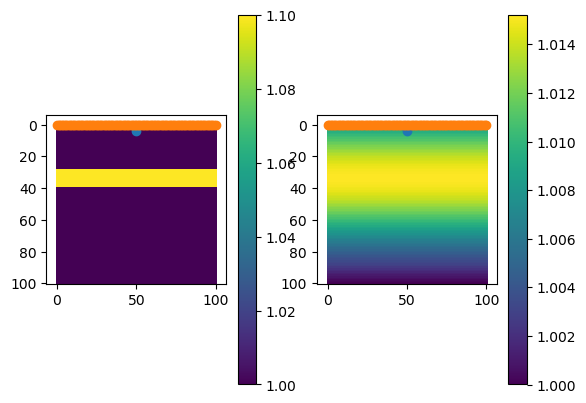

PyObject <matplotlib.collections.PathCollection object at 0x1469c9128>

In [2]:
Nx = 101;
Ny = 101;
h = 0.01;

Nt = 1001;
Fs = 500;
dt = 1/Fs;
t = range(0, length=Nt, step=dt);

# source
# f = sin.(2*pi*5*t);
f = source_ricker(5,0.2,t)
source_num = 1
source = zeros(Nt, source_num);
for i = 1:source_num
    source[:,i] = f;
end
source_position = zeros(Int, source_num, 2);
for i = 1:source_num
    source_position[i,1] = 5;
#     source_position[i,2] = 10*i;
    source_position[i,2] = 51;
end

# receiver
receiver_num = 101;
receiver_position = zeros(Int, receiver_num, 2);
for i = 1:receiver_num
    receiver_position[i,1] = 1
    receiver_position[i,2] = i
end

# model
c = 1*ones(Nx,Ny);
rho = 1*ones(Nx,Ny);
c[30:40,:] .= 1.1;

using ImageFiltering
c0 = imfilter(c, Kernel.gaussian(30));

subplot(121)
imshow(c); colorbar()
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(122)
imshow(c0); colorbar()
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

In [3]:
a = 1 ./ (c.^2 .* rho);
a0 = 1 ./ (c0.^2 .* rho);

### Simulate

In [4]:
@time received_data, wavefield = multi_solver(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position);

  8.623833 seconds (8.39 M allocations: 10.864 GiB, 18.24% gc time)


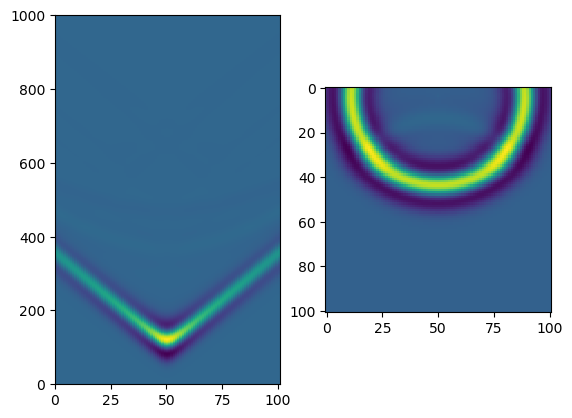

PyObject <matplotlib.image.AxesImage object at 0x15b97cba8>

In [9]:
subplot(121); pcolor(received_data[:,:,1])
subplot(122); imshow(wavefield[:,:,300,1])

### Forward modelling

In [14]:
@time d, u =  multi_solver(c0, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position);

  6.390107 seconds (273.21 k allocations: 10.475 GiB, 21.42% gc time)


### Adjoint method

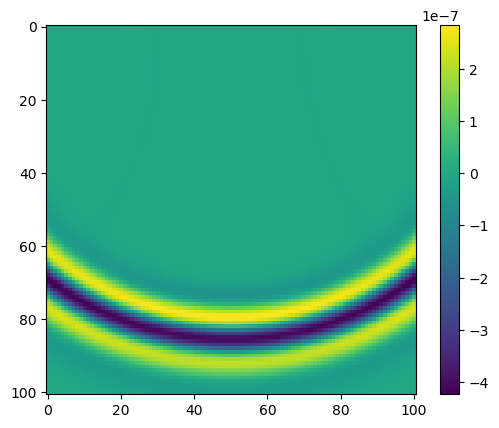

PyObject <matplotlib.colorbar.Colorbar object at 0x14dce8e80>

In [25]:
utt = similar(u);
for i = 2:Nt-1
    utt[:,:,i,:] = (u[:,:,i+1,:]-2*u[:,:,i,:]+u[:,:,i-1,:]) ./ (2*dt);
end
utt[:,:,:,:] = utt[:,:,end:-1:1,:];
imshow(utt[:,:,490,1]); colorbar()

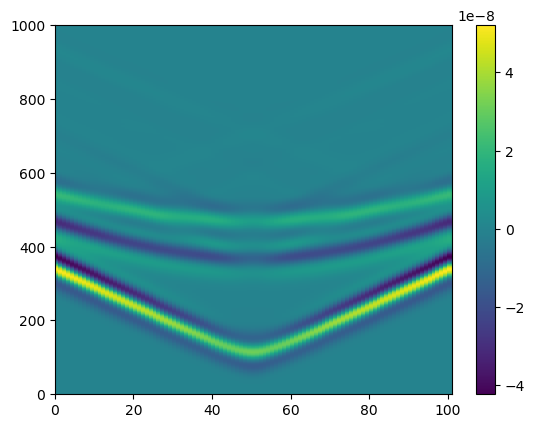

PyObject <matplotlib.colorbar.Colorbar object at 0x14cc1fa58>

In [16]:
# adjoint source
adj_source1 = d - received_data;
pcolor(adj_source1[:,:,1]); colorbar()

Test W2 adjoint

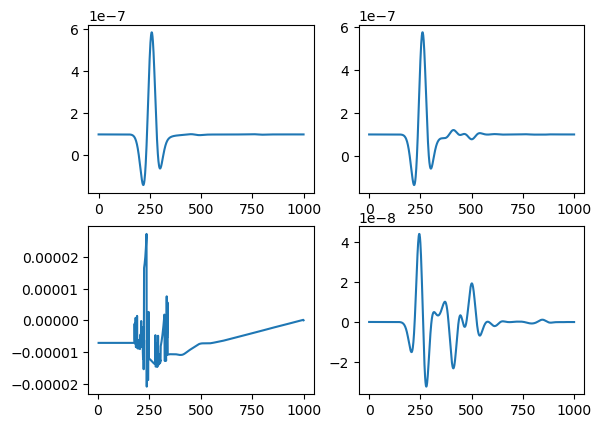

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141ae0390>

In [32]:
ind_receiver = 20; ind_source = 1;
f = d[:, ind_receiver, ind_source]
g = received_data[:, ind_receiver, ind_source]
fmin = minimum(f);
gmin = minimum(g);
# f = f .+ 1.1*min(fmin,gmin)
# g = g .+ 1.1*min(fmin,gmin)
f = f .+ 1e-7;
g = g .+ 1e-7;
# f = abs.(f);
# g = abs.(g);
sig = compute_adj_source_core(f, g, t, Nt, dt);

subplot(221); plot(f)
subplot(222); plot(g)
subplot(223); plot(sig)
subplot(224); plot(f-g)

In [33]:
adj_source = zeros(Nt, receiver_num, source_num)
for ind_source = 1:source_num
    for ind_receiver = 1:receiver_num
        f = d[:, ind_receiver, ind_source]
        g = received_data[:, ind_receiver, ind_source]
#         fmin = minimum(f);
#         gmin = minimum(g);
#         f = f .+ 1.5*min(fmin,gmin)
#         g = g .+ 1.5*min(fmin,gmin)
        f = abs.(f); g = abs.(g);
        adj_source[:,ind_receiver,ind_source] = compute_adj_source_core(f, g, t, Nt, dt);
    end
end

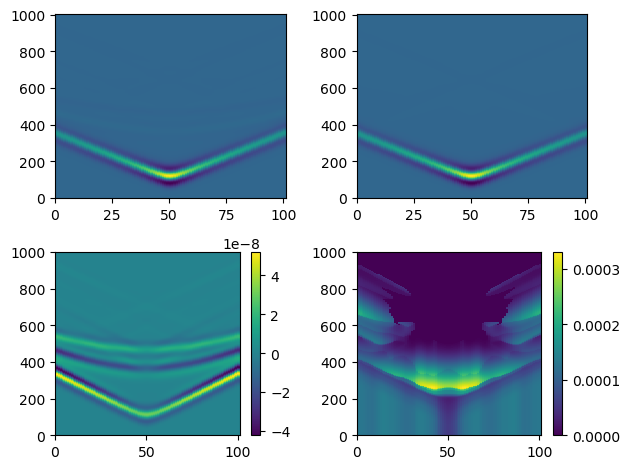

In [34]:
subplot(221); pcolor(received_data[:,:,1])
subplot(222); pcolor(d[:,:,1])
subplot(223); pcolor(adj_source1[:,:,1]); colorbar()
subplot(224); pcolor(adj_source[:,:,1]); colorbar()
tight_layout()

In [35]:
# backward wavefield
v = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position);
v1 = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, adj_source1, source_position, receiver_position);

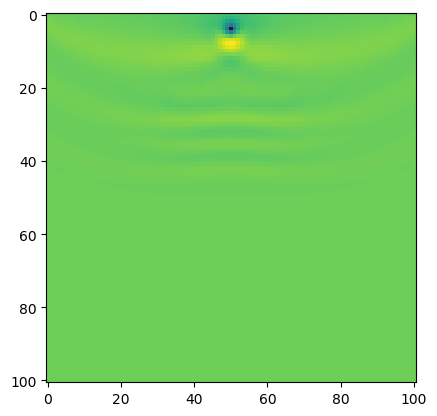

PyObject <matplotlib.image.AxesImage object at 0x17528b320>

In [36]:
# Integration 
grad = zeros(Nx, Ny);
for i = 1:source_num
    g = utt[:,:,:,i] .* v1[:,:,:,i];
    g = sum(g, dims=3)
    grad += g[:,:,1];
end
imshow(grad)

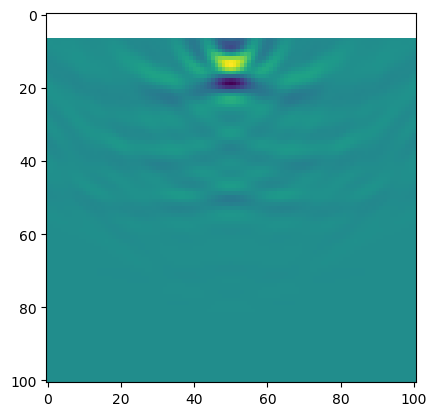

PyObject <matplotlib.image.AxesImage object at 0x15c521ef0>

In [37]:
grad = zeros(Nx, Ny);
for i = 1:source_num
    g = utt[:,:,:,i] .* v[:,:,:,i];
    g = sum(g, dims=3)
    grad += g[:,:,1];
end
grad[findall(x->x==NaN,grad)] .= 0
imshow(grad)